# Setup

In [49]:
import IPython
import IPython.display

import math
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from pytz import timezone
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
tf.config.run_functions_eagerly(False)
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.keras
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, TimeDistributed, Concatenate, Flatten, RepeatVector

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [50]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
df = pd.read_csv('master_df_cleaned-no_col.csv')

In [54]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Actual frequency,18044.0,50.001593,0.020458,49.875,49.987000,50.00300,50.01600,50.095
FCR Requested,18044.0,-0.695332,8.948207,-41.800,-6.880000,-1.29000,5.59000,55.000
System imbalance,18044.0,-13.274181,207.248432,-1282.136,-131.409250,-9.42400,111.32350,1210.216
Net regulation volume,18044.0,13.399773,178.864846,-1141.483,-89.849000,8.05350,112.03425,1108.754
GUV,18044.0,87.706228,118.568856,0.000,0.153750,39.32650,134.94425,1114.579
IGCC+,18044.0,36.672182,65.314898,0.000,0.000000,3.40650,46.65700,718.871
aFRR+,18044.0,17.048799,31.984912,0.000,0.000000,0.56750,15.54775,204.527
GDV,18044.0,74.306455,104.307765,0.000,0.074750,28.13200,114.80250,1141.483
IGCC-,18044.0,40.094627,67.613132,0.000,0.000000,6.53550,54.10975,861.426
aFRR-,18044.0,20.008043,40.560677,0.000,0.000000,0.75200,18.41650,382.141


# Pre-Processing

## Converting wind speed and wind direction into a wind vector

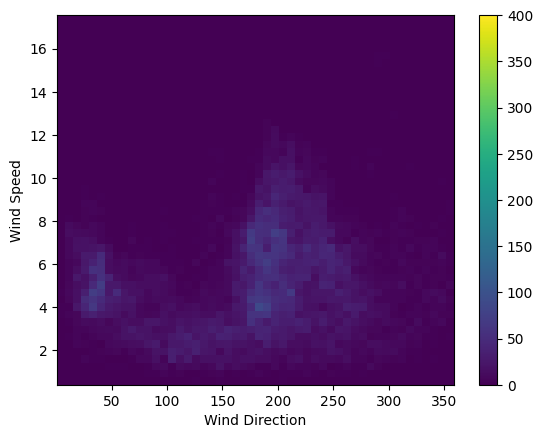

In [55]:
plt.hist2d(df['weath_wind_direction'], df['weath_wind_speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed')
plt.show()

In [56]:
wv = df.pop('weath_wind_speed')

In [57]:
# Convert to radians.
wd_rad = df.pop('weath_wind_direction')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

(-12.398632809542018,
 10.420112879284103,
 -15.746884387784464,
 8.564924234596901)

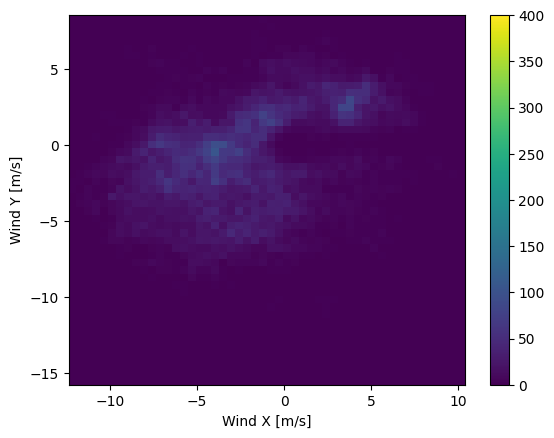

In [58]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [59]:
# Convert Unnamed: 0 to datetime
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])

In [60]:
# Change the order of the columns to descending based on the Unnamed: 0 column
df = df.sort_values(by=['Unnamed: 0'], ascending=True)

In [61]:
df.head()

,Unnamed: 0,Actual frequency,FCR Requested,System imbalance,Net regulation volume,GUV,IGCC+,aFRR+,GDV,IGCC-,...,Monitored capacity,Load factor,Total Load,wp_Measured & Upscaled,wp_Monitored capacity,wp_Load factor,weath_air_temperature,weath_precipitation,Wx,Wy
18043,2022-10-31 23:00:00,50.016,-6.88,373.608,-394.779,26.397,26.397,0.000,421.176,16.204,...,18545.413,0.0,7507.48,3898.73,5041.05,3.40,15.7100,0.0,-8.079392,1.486490
18042,2022-10-31 23:15:00,50.000,0.00,-16.578,34.556,134.556,15.676,118.880,100.000,0.000,...,18545.413,0.0,7428.68,3857.75,5041.05,3.32,15.7200,0.0,-8.424247,1.094119
18041,2022-10-31 23:30:00,49.991,3.87,-274.545,124.253,124.253,69.796,54.457,0.000,0.000,...,18545.413,0.0,7238.46,3897.11,5041.05,3.37,15.6725,0.0,-7.974817,0.873385
18040,2022-10-31 23:45:00,50.015,-6.45,309.890,-206.948,50.000,0.000,0.000,256.948,217.215,...,18545.413,0.0,6987.90,3905.52,5041.05,3.39,15.7650,0.0,-8.049865,0.697194
18039,2022-11-01 00:00:00,50.016,-6.88,160.017,-138.693,0.000,0.000,0.000,138.693,128.323,...,18545.413,0.0,7022.95,3858.28,5041.05,3.31,15.9050,0.0,-8.699601,0.425481


Standard practice for wind speed pre-processing. Note to self - include some of the articles about wind predictions in the paper

# Converting "Actual Frequency" into "Frequency Deviations"

In [62]:
# Subtract 50 from the Actual frequency column for all entries
df['Actual frequency'] = df['Actual frequency'] - 50

In [63]:
df.rename(columns={'Actual frequency': 'Actual frequency deviation'}, inplace=True)

In [64]:
# Set date as index
df.set_index('Unnamed: 0', inplace=True)

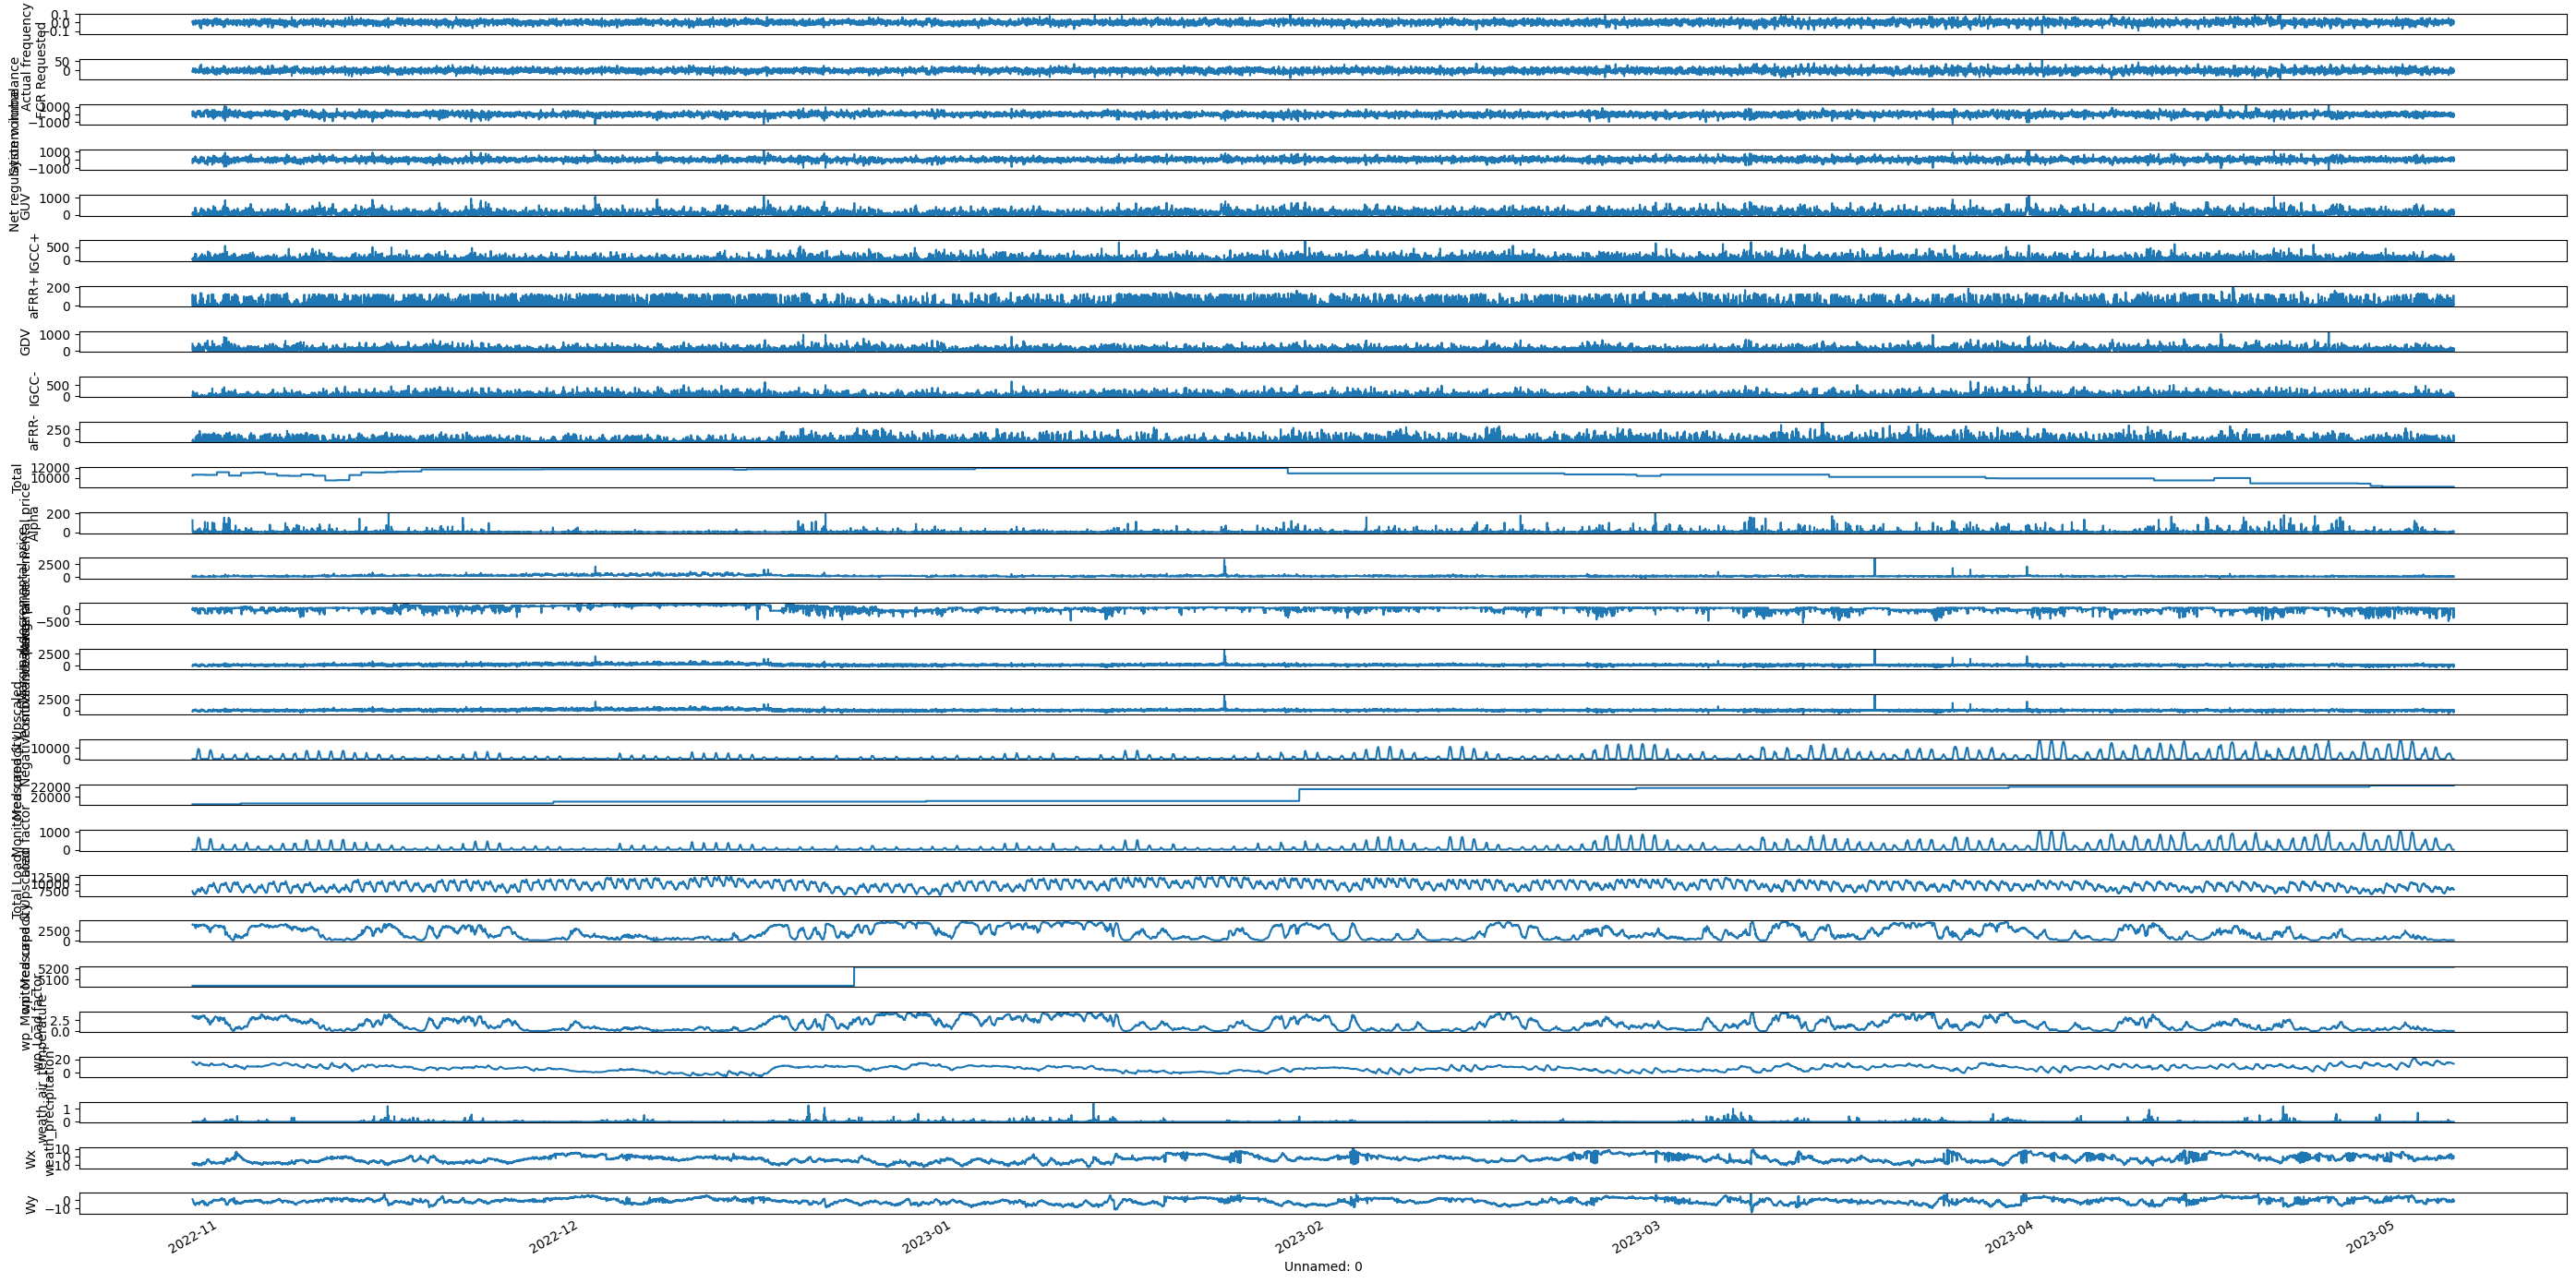

In [65]:
# Plot line charts
df_plot = df.copy()

ncols = 1
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(28, 14))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()

# Part 1 - Comparing the different time series models

For LSTM, use the code where a bunch of variables have been dropped. The goal here is to create a model with the least amount of errors. Compare the results with XGBoost Regression and Yurdakul's results.

In [66]:
# Drop the redundant columns
df = df.drop(['FCR Requested', 'System imbalance', 'Measured & Upscaled', 'Load factor', 'wp_Load factor', 'Net regulation volume', 'Total','Monitored capacity', 'wp_Monitored capacity', 'GDV', 'Negative imbalance price', 'wp_Measured & Upscaled', 'GUV', 'Positive imbalance price'], axis=1)

In [67]:
# List all column names
df.columns

Index(['Actual frequency deviation', 'IGCC+', 'aFRR+', 'IGCC-', 'aFRR-',
       'Alpha', 'Marginal incremental price', 'Marginal decremental price',
       'Total Load', 'weath_air_temperature', 'weath_precipitation', 'Wx',
       'Wy'],
      dtype='object')

### LSTM

In [68]:
# Indexing Batches
train_df = df.sort_index().copy()

# List of considered Features
FEATURES =['Actual frequency deviation', 'IGCC+', 'aFRR+', 'IGCC-', 'aFRR-',
       'Alpha', 'Marginal incremental price', 'Marginal decremental price',
       'Total Load', 'weath_air_temperature', 'weath_precipitation', 'Wx',
       'Wy']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Actual frequency deviation']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Actual frequency deviation', 'IGCC+', 'aFRR+', 'IGCC-', 'aFRR-', 'Alpha', 'Marginal incremental price', 'Marginal decremental price', 'Total Load', 'weath_air_temperature', 'weath_precipitation', 'Wx', 'Wy']


,Actual frequency deviation,IGCC+,aFRR+,IGCC-,aFRR-,Alpha,Marginal incremental price,Marginal decremental price,Total Load,weath_air_temperature,weath_precipitation,Wx,Wy,Prediction
Unnamed: 0,,,,,,,,,,,,,,
2023-05-07 20:45:00,0.028,0.000,0.000,72.559,4.592,0.00,227.82,49.87,8201.35,13.4800,0.0,-1.722277,0.814117,0.028
2023-05-07 21:00:00,-0.001,0.000,0.000,123.344,25.950,0.80,141.50,46.85,8187.23,13.4775,0.0,-1.008936,-1.550661,-0.001
2023-05-07 21:15:00,-0.021,64.350,108.593,0.000,0.000,11.85,230.03,50.70,8096.30,13.5300,0.0,-1.532939,0.933875,-0.021
2023-05-07 21:30:00,0.019,0.630,0.000,38.120,126.942,0.00,141.50,-359.17,7914.45,13.5675,0.0,-1.198162,0.738556,0.019
2023-05-07 21:45:00,0.012,135.757,4.603,0.000,0.000,0.79,141.50,50.70,7994.16,13.5450,0.0,0.883604,-1.297746,0.012


In [105]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
np_data_scaled = scaler.fit_transform(np_data_unscaled)


# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Return = pd.DataFrame(data_filtered_ext['Actual frequency deviation'])
np_Return_scaled = scaler_pred.fit_transform(df_Return)

(18044, 13)


In [107]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 36

# Prediction Index
index_Return = data.columns.get_loc("Actual frequency deviation")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Return]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Return])
print(y_train[0])

AttributeError: ignored

#### Single Layer

In [71]:
# # Configure the neural network model
# model = Sequential()

# # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
# n_neurons = 650
# print(n_neurons, x_train.shape[1], x_train.shape[2])
# model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]),
#                recurrent_activation='tanh', activation='relu', recurrent_dropout=0.001, dropout=0.01))
# model.add(Dense(15, activation='tanh'))
# model.add(Dense(1, activation='tanh'))

# # Compile the model
# learning_rate = 0.0001
# optimizer = Adam(learning_rate=learning_rate)

# model.compile(optimizer=optimizer, loss='mse')

In [72]:
# model.summary()

In [73]:
# # Training the model
# epochs = 30
# batch_size = 128
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_data=(x_test, y_test),
#                     callbacks=[tensorboard_callback]
#                    )

In [74]:
# # Get the predicted values
# y_pred_scaled = model.predict(x_test)

# # Unscale the predicted values
# y_pred = scaler_pred.inverse_transform(y_pred_scaled)
# y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# # Mean Absolute Error (MAE)
# MAE = mean_absolute_error(y_test_unscaled, y_pred)
# print(f'Median Absolute Error (MAE): {np.round(MAE, 4)}')

# # Mean Absolute Percentage Error (MAPE) - In frequency deviation terms
# MAPE = np.mean((np.abs(np.subtract((y_test_unscaled),( y_pred))/ (y_test_unscaled)))) * 100
# print(f'Mean Absolute Percentage Error (MAPE) - In frequency deviation terms: {np.round(MAPE, 4)} %')

# # Median Absolute Percentage Error (MDAPE) - In frequency deviation terms
# MDAPE = np.median((np.abs(np.subtract((y_test_unscaled),( y_pred))/ (y_test_unscaled))) ) * 100
# print(f'Median Absolute Percentage Error (MDAPE) - In frequency deviation terms: {np.round(MDAPE, 4)} %')

# # Mean Absolute Percentage Error (MAPE) - In frequency terms
# MAPE = np.mean((np.abs(np.subtract((y_test_unscaled+50),( y_pred+50))/ (y_test_unscaled+50)))) * 100
# print(f'Mean Absolute Percentage Error (MAPE) - In frequency terms: {np.round(MAPE, 4)} %')

# # Median Absolute Percentage Error (MDAPE) - In frequency terms
# MDAPE = np.median((np.abs(np.subtract((y_test_unscaled+50),( y_pred+50))/ (y_test_unscaled+50))) ) * 100
# print(f'Median Absolute Percentage Error (MDAPE) - In frequency terms: {np.round(MDAPE, 4)} %')

# # Root Mean Square Error (RMSE)
# RMSE = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
# print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 4)}')

# # Mean Squared Error (MSE)
# MSE = mean_squared_error(y_test_unscaled, y_pred)
# print(f'Mean Squared Error (MSE): {np.round(MSE, 4)}')

In [75]:
# # Display the first 5 predictions and the real values
# for i in range(0, 5):
#     print(f'Predicted value: {y_pred[i]} | Actual value: {y_test[i]}')

# # Plot the predicted (scaled) vs the actual (scaled) values
# fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
# sns.lineplot(y_test.flatten()[2000:2200], label="Actual")
# sns.lineplot(y_pred_scaled.flatten()[2000:2200], label="Predicted")
# plt.ylabel("Actual frequency deviation")
# plt.xlabel("Time Step")
# plt.legend()
# plt.show()

#### 2-Layer

In [76]:
# # Configure the neural network model
# model_2 = Sequential()

# # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
# n_neurons = 650
# print(n_neurons, x_train.shape[1], x_train.shape[2])
# model_2.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), recurrent_activation='tanh', activation='relu', recurrent_dropout=0.001, dropout=0.01))
# model_2.add(LSTM(n_neurons, return_sequences=False, activation='relu', recurrent_activation='tanh', recurrent_dropout=0.001, dropout=0.01))
# model_2.add(Dense(15, activation='tanh'))
# model_2.add(Dense(1, activation='tanh'))

# # Compile the model
# learning_rate = 0.0001
# optimizer = Adam(learning_rate=learning_rate)

# model_2.compile(optimizer=optimizer, loss='mse')

In [77]:
# # Training the model
# epochs = 30
# batch_size = 128
# history_2 = model_2.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_data=(x_test, y_test),
#                     callbacks=[tensorboard_callback]
#                    )

In [78]:
# model_2.summary()

In [79]:
from tensorflow.keras.models import load_model

model_2 = load_model('model_2 (2).h5')


In [80]:
# Get the predicted values
y_pred_scaled_2 = model_2.predict(x_test)

# Unscale the predicted values
y_pred_2 = scaler_pred.inverse_transform(y_pred_scaled_2)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred_2)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 4)}')

# Mean Absolute Percentage Error (MAPE) - In frequency deviation terms
MAPE = np.mean((np.abs(np.subtract((y_test_unscaled),( y_pred_2))/ (y_test_unscaled)))) * 100
print(f'Mean Absolute Percentage Error (MAPE) - In frequency deviation terms: {np.round(MAPE, 4)} %')

# Median Absolute Percentage Error (MDAPE) - In frequency deviation terms
MDAPE = np.median((np.abs(np.subtract((y_test_unscaled),( y_pred_2))/ (y_test_unscaled))) ) * 100
print(f'Median Absolute Percentage Error (MDAPE) - In frequency deviation terms: {np.round(MDAPE, 4)} %')

# Mean Absolute Percentage Error (MAPE) - In frequency terms
MAPE = np.mean((np.abs(np.subtract((y_test_unscaled+50),( y_pred_2+50))/ (y_test_unscaled+50)))) * 100
print(f'Mean Absolute Percentage Error (MAPE) - In frequency terms: {np.round(MAPE, 4)} %')

# Median Absolute Percentage Error (MDAPE) - In frequency terms
MDAPE = np.median((np.abs(np.subtract((y_test_unscaled+50),( y_pred_2+50))/ (y_test_unscaled+50))) ) * 100
print(f'Median Absolute Percentage Error (MDAPE) - In frequency terms: {np.round(MDAPE, 4)} %')

# Root Mean Square Error (RMSE)
RMSE = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_2))
print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 4)}')

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_test_unscaled, y_pred_2)
print(f'Mean Squared Error (MSE): {np.round(MSE, 4)}')

Mean Absolute Error (MAE): 0.03
Mean Absolute Percentage Error (MAPE) - In frequency deviation terms: 89.2266 %
Median Absolute Percentage Error (MDAPE) - In frequency deviation terms: 26.4694 %
Mean Absolute Percentage Error (MAPE) - In frequency terms: 0.0602 %
Median Absolute Percentage Error (MDAPE) - In frequency terms: 0.0509 %
Root Mean Square Error (RMSE): 0.0381
Mean Squared Error (MSE): 0.0015


NameError: ignored

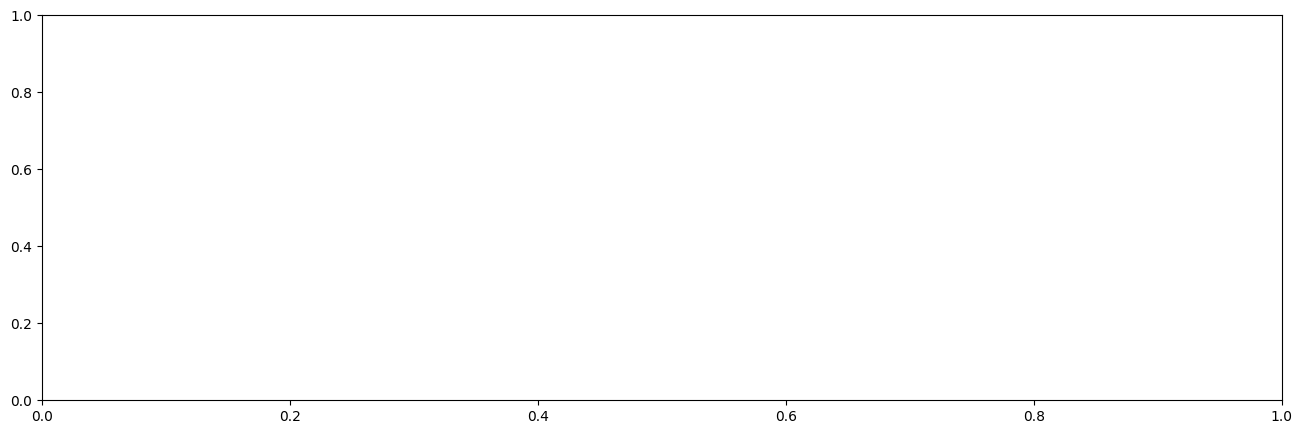

In [81]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history_2.history["loss"])  # Train loss
sns.lineplot(data=history_2.history["val_loss"])  # Validation loss
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
legend = plt.legend(["Train", "Validation"])  # Update legend labels
legend.legendHandles[1].set_color('orange')  # Change the color of the 'Validation' line in the legend
plt.grid()
plt.show()


Predicted value: [-0.08996811] | Actual value: -0.09090909090907329
Predicted value: [-0.0931163] | Actual value: 0.24545454545455603
Predicted value: [-0.07575409] | Actual value: 0.09090909090907329
Predicted value: [-0.08215219] | Actual value: 0.13636363636364224
Predicted value: [-0.08835687] | Actual value: 0.1272727272727543


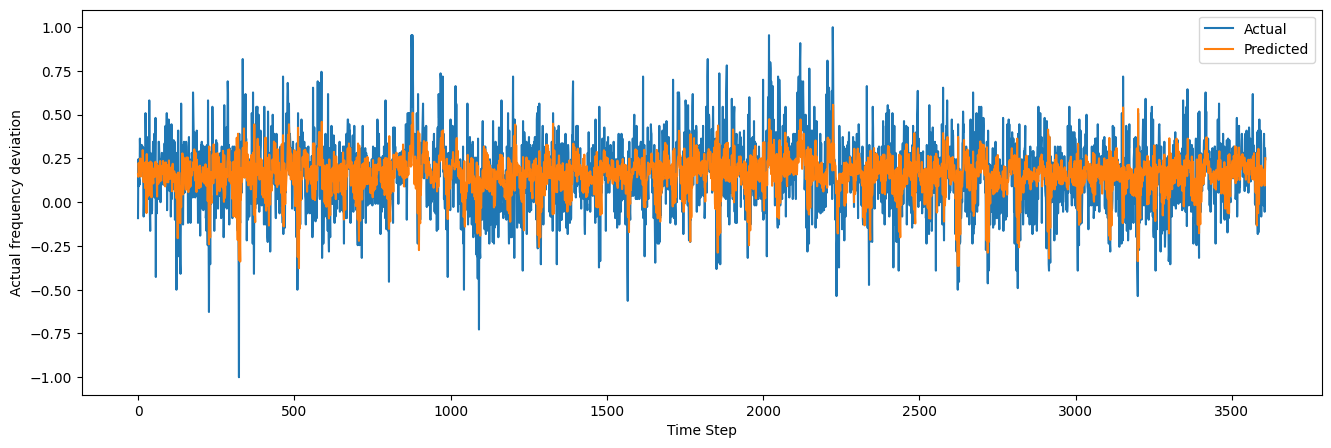

In [102]:
# Display the first 5 predictions and the real values
for i in range(0, 5):
    print(f'Predicted value: {y_pred_2[i]} | Actual value: {y_test[i]}')

# Plot the predicted (scaled) vs the actual (scaled) values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(y_test.flatten()[:], label="Actual")
sns.lineplot(y_pred_scaled_2.flatten()[:], label="Predicted")
plt.ylabel("Actual frequency deviation")
plt.xlabel("Time Step")
plt.legend()
plt.show()

In [ ]:
y_pred_2[0:20]

In [ ]:
y_test[0:20]

In [ ]:
model_2.save('model_2.h5')

#### 3-Layer

In [ ]:
# # Configure the neural network model
# model_3 = Sequential()

# # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
# n_neurons = 650
# print(n_neurons, x_train.shape[1], x_train.shape[2])
# model_3.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), recurrent_activation='tanh', activation='relu', recurrent_dropout=0.001, dropout=0.001))
# model_3.add(LSTM(n_neurons, return_sequences=True, activation='relu', recurrent_activation='tanh', recurrent_dropout=0.001, dropout=0.01))
# model_3.add(LSTM(n_neurons, return_sequences=False, activation='relu', recurrent_activation='tanh', recurrent_dropout=0.001, dropout=0.1))
# model_3.add(Dense(15, activation='tanh'))
# model_3.add(Dense(8, activation='tanh'))
# model_3.add(Dense(1, activation='tanh'))

# # Compile the model
# learning_rate = 0.001
# optimizer = Adam(learning_rate=learning_rate)

# model_3.compile(optimizer=optimizer, loss='mse')

In [ ]:
# model_3.summary()

In [ ]:
# # Training the model
# epochs = 30
# batch_size = 128
# history = model_3.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_data=(x_test, y_test),
#                     callbacks=[tensorboard_callback]
#                    )

In [ ]:
# # Get the predicted values
# y_pred_scaled_3 = model_3.predict(x_test)

# # Unscale the predicted values
# y_pred_3 = scaler_pred.inverse_transform(y_pred_scaled_3)
# y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# # Mean Absolute Error (MAE)
# MAE = mean_absolute_error(y_test_unscaled, y_pred_3)
# print(f'Median Absolute Error (MAE): {np.round(MAE, 4)}')

# # Mean Absolute Percentage Error (MAPE) - In frequency deviation terms
# MAPE = np.mean((np.abs(np.subtract((y_test_unscaled),( y_pred_3))/ (y_test_unscaled)))) * 100
# print(f'Mean Absolute Percentage Error (MAPE) - In frequency deviation terms: {np.round(MAPE, 4)} %')

# # Median Absolute Percentage Error (MDAPE) - In frequency deviation terms
# MDAPE = np.median((np.abs(np.subtract((y_test_unscaled),( y_pred_3))/ (y_test_unscaled))) ) * 100
# print(f'Median Absolute Percentage Error (MDAPE) - In frequency deviation terms: {np.round(MDAPE, 4)} %')

# # Mean Absolute Percentage Error (MAPE) - In frequency terms
# MAPE = np.mean((np.abs(np.subtract((y_test_unscaled+50),( y_pred_3+50))/ (y_test_unscaled+50)))) * 100
# print(f'Mean Absolute Percentage Error (MAPE) - In frequency terms: {np.round(MAPE, 4)} %')

# # Median Absolute Percentage Error (MDAPE) - In frequency terms
# MDAPE = np.median((np.abs(np.subtract((y_test_unscaled+50),( y_pred_3+50))/ (y_test_unscaled+50))) ) * 100
# print(f'Median Absolute Percentage Error (MDAPE) - In frequency terms: {np.round(MDAPE, 4)} %')

# # Root Mean Square Error (RMSE)
# RMSE = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_3))
# print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 4)}')

# # Mean Squared Error (MSE)
# MSE = mean_squared_error(y_test_unscaled, y_pred_3)
# print(f'Mean Squared Error (MSE): {np.round(MSE, 4)}')

In [ ]:
# # Display the first 5 predictions and the real values
# for i in range(0, 5):
#     print(f'Predicted value: {y_pred_3[i]} | Actual value: {y_test[i]}')

# # Plot the predicted (scaled) vs the actual (scaled) values
# fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
# sns.lineplot(y_test.flatten()[2000:2200], label="Actual")
# sns.lineplot(y_pred_scaled_3.flatten()[2000:2200], label="Predicted")
# plt.ylabel("Actual frequency deviation")
# plt.xlabel("Time Step")
# plt.legend()
# plt.show()

In [ ]:
# y_pred_3[0:20]

In [ ]:
# y_test[0:20]

# SHAP Implementation

## Global Explanations

In [83]:
! pip install shap

In [84]:
# Import the shap library
import shap

In [85]:
# Select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Create a DeepExplainer object
explainer = shap.DeepExplainer(model_2, background)

In [86]:
# Calculate the shap values for the entire test set
shap_values_test = explainer.shap_values(x_test)

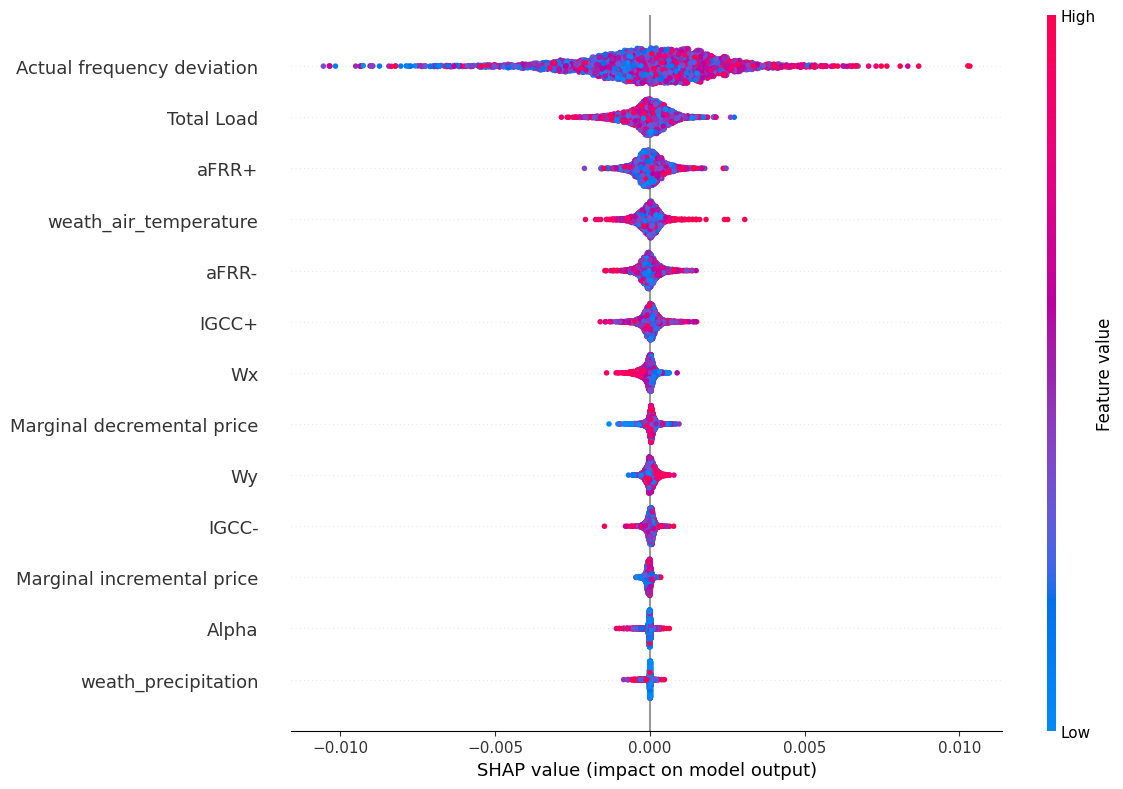

In [87]:
# Average SHAP values over all time steps
shap_values_array = np.array(shap_values_test)
shap_values_avg = shap_values_array.mean(axis=2)
shap_values_avg = shap_values_avg.squeeze(axis=0)

# Average your input data over all time steps
x_test_avg = x_test.mean(axis=1)

x_test_avg_df = pd.DataFrame(x_test_avg, columns=FEATURES)

# Plot the summary plot using these averaged values
shap.summary_plot(shap_values_avg, x_test_avg_df, plot_size=(12, 8))


In [ ]:
print(shap_values_array.shape)

Adapted from: https://github.com/rg727/LSTM_DeepShap/blob/main/LSTM_SHAP.ipynb



In [88]:
from keras import backend as K

In [89]:
#Deep Shap Implementation (Training)
random_ind = np.random.choice(x_train.shape[0], 14000, replace=False)
data = x_train[random_ind[13500:]]
e = shap.DeepExplainer((model_2.layers[0].input, model_2.layers[-1].output),data,K.get_session())
#Deep Shap Testing
test1 = x_train[random_ind[0:1000]]
shap_values = e.shap_values(test1)
shap_val = np.array(shap_values)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.mean(shap_abs,axis=0)

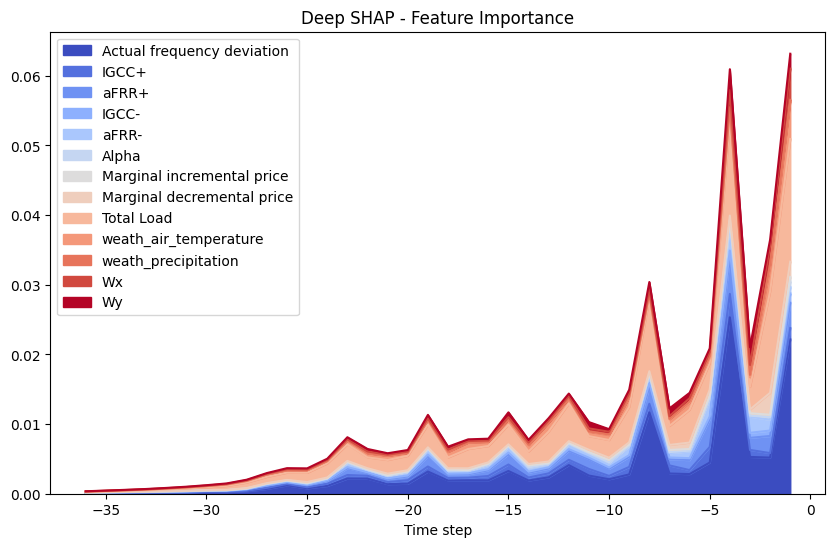

In [90]:
shap_plot = pd.DataFrame(sum_0, columns=FEATURES)
shap_plot['Time step'] = [i-37 for i in list(range(1,37))]
shap_plot.head()
shap_plot.plot.area(x='Time step',figsize=(10, 6), cmap='coolwarm')
plt.title("Deep SHAP - Feature Importance")
plt.show()

Feature importance

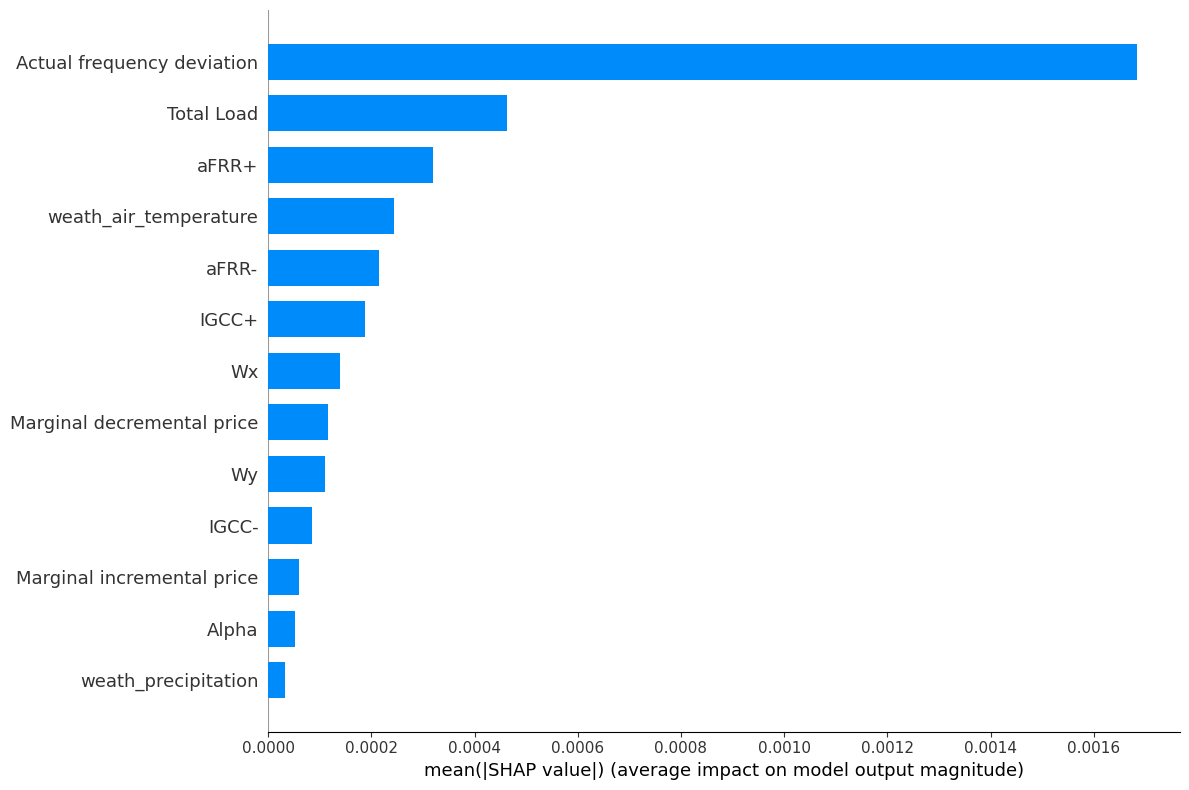

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [91]:
#np.shape(shap_values[0])
shap.summary_plot(shap_values_avg, feature_names=FEATURES, plot_type="bar", plot_size=(12,8))
plt.gcf()


In [92]:
mean_abs_shap_values = np.mean(np.abs(shap_values_avg), axis=0)


In [93]:
mean_abs_shap_values_df = pd.DataFrame({
    'Feature': FEATURES,
    'Mean_Absolute_SHAP': mean_abs_shap_values
})

print(mean_abs_shap_values_df)


                       Feature  Mean_Absolute_SHAP
0   Actual frequency deviation            0.001683
1                        IGCC+            0.000188
2                        aFRR+            0.000319
3                        IGCC-            0.000085
4                        aFRR-            0.000215
5                        Alpha            0.000051
6   Marginal incremental price            0.000061
7   Marginal decremental price            0.000116
8                   Total Load            0.000463
9        weath_air_temperature            0.000243
10         weath_precipitation            0.000032
11                          Wx            0.000139
12                          Wy            0.000111


## Local explanations

In [94]:
# Create a pandas DataFrame for the unscaled predictions
df_preds = pd.DataFrame(y_pred_2, columns=['Predicted Frequency deviation'])

# Get the indices of the max and min predicted frequency deviation
max_index = df_preds['Predicted Frequency deviation'].idxmax()
min_index = df_preds['Predicted Frequency deviation'].idxmin()

print(f"The index of the highest predicted frequency deviation in the test set: {max_index}")
print(f"The index of the lowest predicted frequency deviation in the test set: {min_index}")

The index of the highest predicted frequency deviation in the test set: 2224
The index of the lowest predicted frequency deviation in the test set: 515


In [95]:
# Indices for the high frequency and low frequency scenarios
high_freq_idx = [max_index]
low_freq_idx = [min_index]

# Get the shap_values for the high and low frequency instances
shap_values_high = explainer.shap_values(x_test[high_freq_idx])
shap_values_low = explainer.shap_values(x_test[low_freq_idx])

# Extract the specific shap_values from the list
high_freq_shap_values = shap_values_high[0][0].mean(axis=-1) # Averaging over the last axis if needed
low_freq_shap_values = shap_values_low[0][0].mean(axis=-1)

## Waterfall plots for extreme scenarios

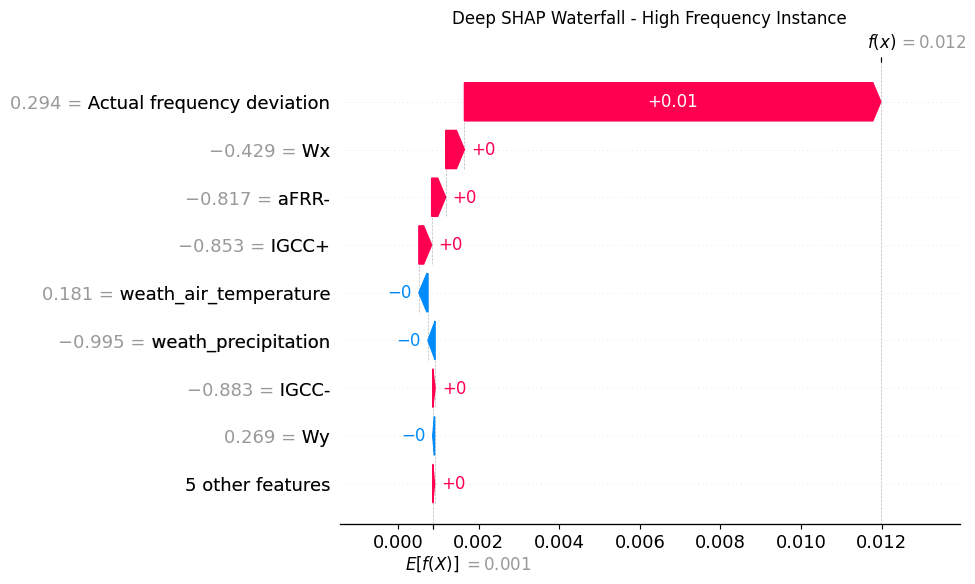

In [96]:
# Make sure high_freq_idx is a specific index, not a list
high_freq_idx = high_freq_idx[0] if isinstance(high_freq_idx, list) else high_freq_idx

# Select the specific SHAP values for the high-frequency instance
high_freq_shap_values = explainer.shap_values(x_test[high_freq_idx:high_freq_idx+1])

# Average the SHAP values over the sequence length
high_freq_shap_values_mean = high_freq_shap_values[0].mean(axis=1).squeeze()

# Take the mean of the feature values across time steps (or select an appropriate time step)
high_freq_features = x_test[high_freq_idx].mean(axis=0)

# Assuming the base value is the same for all instances (you may need to adjust this)
base_values = high_freq_shap_values[0].mean()

# Create an Explanation object
high_freq_explanation = shap.Explanation(values=high_freq_shap_values_mean, base_values=base_values, data=high_freq_features, feature_names=FEATURES)

# Generate the waterfall plot
shap.plots.waterfall(high_freq_explanation, max_display=9, show=False)
plt.title("Deep SHAP Waterfall - High Frequency Instance")
plt.show()


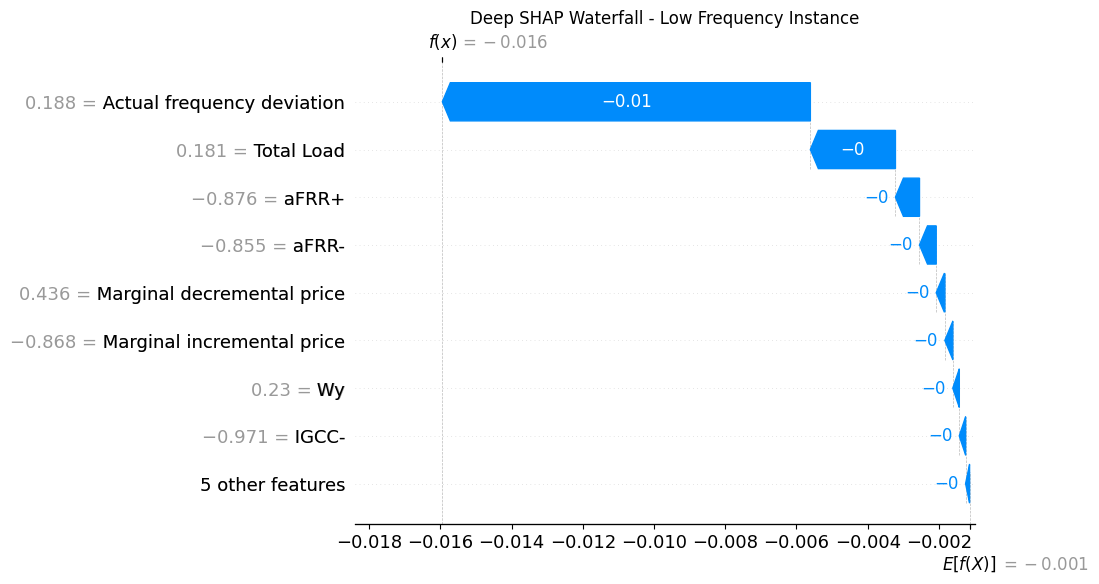

In [97]:
# Make sure low_freq_idx is a specific index, not a list
low_freq_idx = low_freq_idx[0] if isinstance(low_freq_idx, list) else low_freq_idx

# Select the specific SHAP values for the low-frequency instance
low_freq_shap_values = explainer.shap_values(x_test[low_freq_idx:low_freq_idx+1])

# Average the SHAP values over the sequence length
low_freq_shap_values_mean = low_freq_shap_values[0].mean(axis=1).squeeze()

# Take the mean of the feature values across time steps (or select an appropriate time step)
low_freq_features = x_test[low_freq_idx].mean(axis=0)

# Assuming the base value is the same for all instances (you may need to adjust this)
base_values = low_freq_shap_values[0].mean()

# Create an Explanation object
low_freq_explanation = shap.Explanation(values=low_freq_shap_values_mean, base_values=base_values, data=low_freq_features, feature_names=FEATURES)

# Generate the waterfall plot
shap.plots.waterfall(low_freq_explanation, max_display=9, show=False)
plt.title("Deep SHAP Waterfall - Low Frequency Instance")
plt.show()


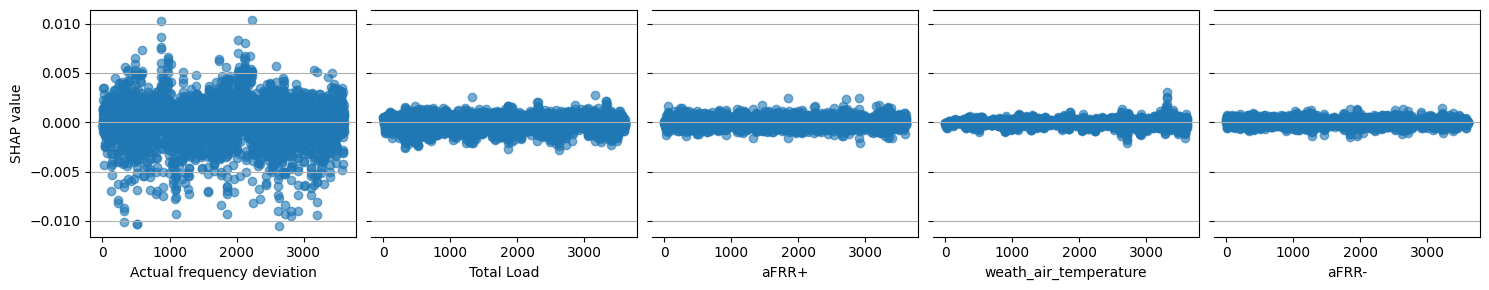

In [98]:
# Assuming shap_values_avg is the SHAP values you want to use
# You may replace it with another variable if needed

# Calculate the mean absolute SHAP values for all features
masv = np.abs(shap_values_avg).mean(axis=0)

# Number of top features to plot
n = 5

# Get the indices of the top n features
top_indices = np.argsort(masv)[::-1][:n]

fig, axs = plt.subplots(1, n, figsize=(15, 3))

# Iterate through the top n features and create scatter plots
for i, idx in enumerate(top_indices):
    ax = axs[i]
    ax.scatter(range(shap_values_avg.shape[0]), shap_values_avg[:, idx], alpha=0.6)
    ax.grid(axis="y")
    if i != 0:
        ax.set_ylabel("")
        ax.spines["left"].set_visible(False)
        ax.set_ylim(axs[0].get_ylim())
        ax.set_yticklabels(["" for _ in range(len(axs[0].get_yticks()))])
    else:
        ax.set_ylabel("SHAP value")
    ax.set_xlabel(FEATURES[idx])

plt.tight_layout()
plt.show()


In [99]:
shap.initjs()
features=FEATURES
shap.force_plot(explainer.expected_value[0],shap_values[0][:,0,:],features=features)